### Notebook to check the dates of the MRI scans

#### Date Sources
1. Suivi sheet 
2. Testing sheet
3. DICOM file 
4. DICOM header

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

In [6]:
dataset_dir  = "/home/nikhil/projects/Parkinsons/qpn/"

current_release = "Jan_2024"
releases_dir = f"{dataset_dir}releases/{current_release}/"


# Current mr_proc manifest
current_manifest_csv = f"{releases_dir}/tabular/manifest.csv"

# Current recruit manifest
current_recruit_manifest_xls = f"{releases_dir}/tabular/demographics/Suivi_RPQ.xlsx"

# Doughnut path
doughnut_path = f"{dataset_dir}/scratch/raw_dicom/doughnut-20240207_1325.csv"   #doughnut-20230919_1433.csv"

# Date check CSV path
date_check_csv = f"{dataset_dir}/scratch/mri_dates_sanity_check.csv"

### Read current manifest

In [7]:
manifest_df= pd.read_csv(current_manifest_csv)

manifest_participants = manifest_df["participant_id"].unique()
n_manifest_participants = len(manifest_participants)
print(f"Number of participants in manifest: {n_manifest_participants}")

sessions = manifest_df["session"].unique()
print(f"sessions: {sessions}")

per_session_counts = manifest_df.value_counts("session")
print(f"per_session_counts: {per_session_counts}")

manifest_df.head()

Number of participants in manifest: 303
sessions: ['ses-01' 'ses-02' 'ses-03']
per_session_counts: session
ses-01    303
ses-02     52
ses-03      4
Name: count, dtype: int64


,participant_id,visit,session,datatype
0,PD00016,MRI_v1,ses-01,"['anat','dwi','fmap','func']"
1,PD00020,MRI_v1,ses-01,"['anat','dwi','fmap','func']"
2,PD00032,MRI_v1,ses-01,"['anat','dwi','fmap','func']"
3,PD00048,MRI_v1,ses-01,"['anat','dwi','fmap','func']"
4,PD00119,MRI_v1,ses-01,"['anat','dwi','fmap','func']"


### Read doughnut data

In [8]:
doughnut_df = pd.read_csv(doughnut_path)

manifest_participants = doughnut_df["participant_id"].unique()
n_manifest_participants = len(manifest_participants)
print(f"Number of participants in manifest: {n_manifest_participants}")

sessions = doughnut_df["session"].unique()
print(f"sessions: {sessions}")

per_session_counts = doughnut_df.value_counts("session")
print(f"per_session_counts: {per_session_counts}")

doughnut_df.head()

Number of participants in manifest: 298
sessions: ['ses-01' 'ses-02']
per_session_counts: session
ses-01    298
ses-02     51
Name: count, dtype: int64


,participant_id,session,participant_dicom_dir,dicom_id,bids_id,downloaded,organized,converted
0,MNI0028,ses-01,MNI0028_152209_MRI01_MNI_20231004_152124681,MNI0028,sub-MNI0028,True,True,True
1,MNI0056,ses-01,MNI0056_864854_MRI01_MNI_20210818_151510608,MNI0056,sub-MNI0056,True,True,True
2,MNI0058,ses-01,MNI0058_197308_MRI01_MNI_20210818_105219098,MNI0058,sub-MNI0058,True,True,True
3,MNI0068,ses-01,MNI0068_842090_MRI01_MNI_20210827_150412426,MNI0068,sub-MNI0068,True,True,True
4,MNI0079,ses-01,MNI0079_760662_MRI01_MNI_20211222_134225878,MNI0079,sub-MNI0079,True,True,True


### Read Suivi_RPQ.xlsx dates for MRI

In [9]:
col_range = "A:R"

col_rename_dict = {
    "subj_id":"participant_id",
    "IRM01\n(J-M-A)":"IRM01_date", "#IRM 1\n PD":"IRM01_PD", "#IRM 1\n CTRL":"IRM01_CTRL", 
    "# IRM 1\n RBD":"IRM01_RBD", "# IRM 1\nOTHER":"IRM01_OTHER",
    "IRM 2 \n(J-M-A)":"IRM02_date", "#IRM 2\n PD":"IRM02_PD", "#IRM 2\n CTRL":"IRM02_CTRL", 
    "# IRM 2\n RBD":"IRM02_RBD", "# IRM 2 OTHER":"IRM02_OTHER",
    "IRM 3\n(J-M-A)":"IRM03_date", "#IRM 3\n PD":"IRM03_PD", "#IRM 3\n CTRL":"IRM03_CTRL", 
    "# IRM 3\n RBD":"IRM03_RBD", "# IRM 3 OTHER":"IRM03_OTHER"
    }

useful_cols = col_rename_dict.values()

suivi_df = pd.read_excel(current_recruit_manifest_xls,sheet_name="En cours", engine='openpyxl', usecols=col_range)
suivi_df = suivi_df.rename(columns=col_rename_dict)[useful_cols].copy()

# remove the row with tally
suivi_df = suivi_df.drop([0])

# remove rows without participant_id
suivi_df = suivi_df.dropna(axis=0, subset=["participant_id"])
suivi_df = suivi_df[~suivi_df["participant_id"].astype(str).isin(["0"])] 

# remove subjects without imaging data
suivi_df = suivi_df[(suivi_df["IRM01_PD"] == 1) | (suivi_df["IRM01_CTRL"] == 1) | 
                    (suivi_df["IRM01_RBD"] == 1) | (suivi_df["IRM01_OTHER"] == 1) |
                    (suivi_df["IRM02_PD"] == 1) | (suivi_df["IRM02_CTRL"] == 1) | 
                    (suivi_df["IRM02_RBD"] == 1) |(suivi_df["IRM02_OTHER"] == 1) |
                    (suivi_df["IRM03_PD"] == 1) | (suivi_df["IRM03_CTRL"] == 1) | 
                    (suivi_df["IRM03_RBD"] == 1) |(suivi_df["IRM03_OTHER"] == 1) ]


# fix participant_id formatting issues
# Some rows have Dx in participant_id and one participant with two IDs with "="
possible_delimiters = [" ", "(", "=", "\n"]
for delim in possible_delimiters:        
    suivi_df["participant_id"] = suivi_df["participant_id"].str.strip().str.split(pat=delim, n=1, expand=True)[0]

# nipoppy_participants_current
nipoppy_participants_current = suivi_df["participant_id"].dropna().unique()

suivi_df

,participant_id,IRM01_date,IRM01_PD,IRM01_CTRL,IRM01_RBD,IRM01_OTHER,IRM02_date,IRM02_PD,IRM02_CTRL,IRM02_RBD,IRM02_OTHER,IRM03_date,IRM03_PD,IRM03_CTRL,IRM03_RBD,IRM03_OTHER
15,PD00016,26-07-2019,1.0,0.0,0.0,NaN,0,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN
19,PD00020,2018-05-12 00:00:00,1.0,0.0,0.0,NaN,24-11-2022,1,0.0,0.0,NaN,0,NaN,NaN,NaN,NaN
31,PD00032,24-07-2019,1.0,0.0,0.0,NaN,0,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN
47,PD00048,21-08-2019,1.0,0.0,0.0,NaN,0,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN
117,PD00119,13-08-2018,1.0,0.0,0.0,NaN,0,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2229,MNI0565,2023-09-11 00:00:00,0.0,1.0,0.0,0.0,0,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN
2231,MNI0602,2023-11-22 00:00:00,1.0,0.0,0.0,0.0,0,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN
2234,MNI0605,15-12-2023,0.0,1.0,0.0,0.0,0,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN
2236,MNI0607,00:00:00,1.0,0.0,0.0,0.0,0,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN


In [10]:
suivi_df[suivi_df["participant_id"].isin(["MNI0224"])]

,participant_id,IRM01_date,IRM01_PD,IRM01_CTRL,IRM01_RBD,IRM01_OTHER,IRM02_date,IRM02_PD,IRM02_CTRL,IRM02_RBD,IRM02_OTHER,IRM03_date,IRM03_PD,IRM03_CTRL,IRM03_RBD,IRM03_OTHER
1793,MNI0224,16-03-2022,0.0,1.0,0.0,NaN,0,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN


In [11]:
# set date columns to datetime
# has mixed types, but auto formatting + coerce works fine here
suivi_df["IRM01_date"] = suivi_df["IRM01_date"].replace(0, np.nan)
suivi_df["IRM02_date"] = suivi_df["IRM02_date"].replace(0, np.nan)

suivi_df["IRM01_date"] = pd.to_datetime(suivi_df["IRM01_date"], errors="coerce")
suivi_df["IRM02_date"] = pd.to_datetime(suivi_df["IRM02_date"], errors="coerce")


# Check visit orders
suivi_df["visit_interval (V2-V1) in days"] = suivi_df["IRM02_date"] - suivi_df["IRM01_date"]
suivi_df["visit_interval (V2-V1) in days"] = suivi_df["visit_interval (V2-V1) in days"].dt.days
visits_wit_wrong_order_df = suivi_df[suivi_df["visit_interval (V2-V1) in days"] < 0]
print(f"Participants with wrong visit order: ({len(visits_wit_wrong_order_df)}) :{visits_wit_wrong_order_df['participant_id'].values}")


suivi_df.head()

Participants with wrong visit order: (0) :[]


/tmp/ipykernel_30496/504833383.py:6: UserWarning: Parsing dates in %d-%m-%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  suivi_df["IRM01_date"] = pd.to_datetime(suivi_df["IRM01_date"], errors="coerce")
/tmp/ipykernel_30496/504833383.py:7: UserWarning: Parsing dates in %d-%m-%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  suivi_df["IRM02_date"] = pd.to_datetime(suivi_df["IRM02_date"], errors="coerce")


,participant_id,IRM01_date,IRM01_PD,IRM01_CTRL,IRM01_RBD,IRM01_OTHER,IRM02_date,IRM02_PD,IRM02_CTRL,IRM02_RBD,IRM02_OTHER,IRM03_date,IRM03_PD,IRM03_CTRL,IRM03_RBD,IRM03_OTHER,visit_interval (V2-V1) in days
15,PD00016,2019-07-26,1.0,0.0,0.0,NaN,NaT,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN
19,PD00020,2018-05-12,1.0,0.0,0.0,NaN,2022-11-24,1,0.0,0.0,NaN,0,NaN,NaN,NaN,NaN,1657.0
31,PD00032,2019-07-24,1.0,0.0,0.0,NaN,NaT,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN
47,PD00048,2019-08-21,1.0,0.0,0.0,NaN,NaT,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN
117,PD00119,2018-08-13,1.0,0.0,0.0,NaN,NaT,NaN,NaN,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN


### Parse and merge dates and visits

In [12]:
suivi_MRI_date_df = suivi_df[['participant_id', 'IRM01_date', 'IRM02_date']].copy()

suivi_MRI_date_df = suivi_MRI_date_df.melt(id_vars=['participant_id'], 
                                   value_vars=['IRM01_date', 'IRM02_date'], 
                                   var_name='visit_id', value_name='suivi_MRI_date')

suivi_MRI_date_df = suivi_MRI_date_df.replace({"visit_id": {"IRM01_date": "MRI_v1", "IRM02_date": "MRI_v2"}})
suivi_MRI_date_df.head()

,participant_id,visit_id,suivi_MRI_date
0,PD00016,MRI_v1,2019-07-26
1,PD00020,MRI_v1,2018-05-12
2,PD00032,MRI_v1,2019-07-24
3,PD00048,MRI_v1,2019-08-21
4,PD00119,MRI_v1,2018-08-13


In [13]:
doughnut_date_df = doughnut_df[["participant_id", "session", "participant_dicom_dir"]].copy()
doughnut_date_df["visit_id"] = doughnut_date_df["participant_dicom_dir"].str.split("_", n=3, expand=True)[2]
doughnut_date_df["dicom_date"] = doughnut_date_df["participant_dicom_dir"].str.split("_", n=5, expand=True)[4]
doughnut_date_df["dicom_date"] = pd.to_datetime(doughnut_date_df["dicom_date"], errors="coerce", yearfirst=True)

participants_with_missing_dicom_visit_tag = doughnut_date_df[doughnut_date_df["visit_id"].isna()]["participant_id"].unique()
print(f"participants_with_missing_dicom_visit_tag: {participants_with_missing_dicom_visit_tag}")
doughnut_date_df.head()

participants_with_missing_dicom_visit_tag: ['MNI0224' 'MNI0301' 'MNI0326' 'MNI0336' 'MNI0350' 'MNI0359' 'MNI0369'
 'MNI0436' 'MNI0607' 'PD00472' 'PD00576' 'PD00583' 'PD00620' 'PD00792'
 'PD00849' 'PD00910' 'PD00911' 'PD01067' 'PD01071' 'PD01100' 'PD01126'
 'PD01134' 'PD01161' 'PD01165' 'PD01199' 'PD01201' 'PD01232' 'PD01237'
 'PD01247' 'PD01268' 'PD01340' 'PD01383' 'PD01500' 'PD01709' 'PD01715']


,participant_id,session,participant_dicom_dir,visit_id,dicom_date
0,MNI0028,ses-01,MNI0028_152209_MRI01_MNI_20231004_152124681,MRI01,2023-10-04
1,MNI0056,ses-01,MNI0056_864854_MRI01_MNI_20210818_151510608,MRI01,2021-08-18
2,MNI0058,ses-01,MNI0058_197308_MRI01_MNI_20210818_105219098,MRI01,2021-08-18
3,MNI0068,ses-01,MNI0068_842090_MRI01_MNI_20210827_150412426,MRI01,2021-08-27
4,MNI0079,ses-01,MNI0079_760662_MRI01_MNI_20211222_134225878,MRI01,2021-12-22


In [14]:
doughnut_date_df[~doughnut_date_df["dicom_date"].isna()].nunique()

participant_id           192
session                    2
participant_dicom_dir    229
visit_id                   2
dicom_date               182
dtype: int64

In [15]:
date_sanity_check_df[~date_sanity_check_df["suivi_MRI_date"].isna()].nunique()

NameError: name 'date_sanity_check_df' is not defined

### Assign doughnut visit tag based on session_id

In [16]:
doughnut_date_df.loc[doughnut_date_df["visit_id"].isna(), "visit_id"] = "MRI" + doughnut_date_df["session"].str.split("-", n=2, expand=True)[1]

participants_with_missing_dicom_visit_tag = doughnut_date_df[doughnut_date_df["visit_id"].isna()]["participant_id"].unique()
print(f"participants_with_missing_dicom_visit_tag: {participants_with_missing_dicom_visit_tag}")
doughnut_date_df["visit_id"] = doughnut_date_df["visit_id"].replace({"MRI01": "MRI_v1", "MRI02":"MRI_v2", "MRI03": "MRI_v3"})
doughnut_date_df.head()

participants_with_missing_dicom_visit_tag: []


,participant_id,session,participant_dicom_dir,visit_id,dicom_date
0,MNI0028,ses-01,MNI0028_152209_MRI01_MNI_20231004_152124681,MRI_v1,2023-10-04
1,MNI0056,ses-01,MNI0056_864854_MRI01_MNI_20210818_151510608,MRI_v1,2021-08-18
2,MNI0058,ses-01,MNI0058_197308_MRI01_MNI_20210818_105219098,MRI_v1,2021-08-18
3,MNI0068,ses-01,MNI0068_842090_MRI01_MNI_20210827_150412426,MRI_v1,2021-08-27
4,MNI0079,ses-01,MNI0079_760662_MRI01_MNI_20211222_134225878,MRI_v1,2021-12-22


### Merge

In [17]:
date_sanity_check_df = pd.merge(doughnut_date_df, suivi_MRI_date_df, on=["participant_id", "visit_id"], how="left")
reorder_cols = ["participant_id", "visit_id", "session", "participant_dicom_dir", "suivi_MRI_date", "dicom_date"]
date_sanity_check_df = date_sanity_check_df[reorder_cols]
date_sanity_check_df["date_match"] = date_sanity_check_df["suivi_MRI_date"] == date_sanity_check_df["dicom_date"]
date_sanity_check_df["date_diff"] = date_sanity_check_df["suivi_MRI_date"] - date_sanity_check_df["dicom_date"]

# Don't count unavailable dates as mismatches 
date_sanity_check_df.loc[date_sanity_check_df["date_diff"].isna(), "date_match"] = np.nan

date_sanity_check_df


/tmp/ipykernel_30496/874610211.py:8: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'nan' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  date_sanity_check_df.loc[date_sanity_check_df["date_diff"].isna(), "date_match"] = np.nan


,participant_id,visit_id,session,participant_dicom_dir,suivi_MRI_date,dicom_date,date_match,date_diff
0,MNI0028,MRI_v1,ses-01,MNI0028_152209_MRI01_MNI_20231004_152124681,NaT,2023-10-04,NaN,NaT
1,MNI0056,MRI_v1,ses-01,MNI0056_864854_MRI01_MNI_20210818_151510608,2021-08-18,2021-08-18,True,0 days
2,MNI0058,MRI_v1,ses-01,MNI0058_197308_MRI01_MNI_20210818_105219098,2021-08-18,2021-08-18,True,0 days
3,MNI0068,MRI_v1,ses-01,MNI0068_842090_MRI01_MNI_20210827_150412426,2021-08-27,2021-08-27,True,0 days
4,MNI0079,MRI_v1,ses-01,MNI0079_760662_MRI01_MNI_20211222_134225878,2021-12-22,2021-12-22,True,0 days
...,...,...,...,...,...,...,...,...
344,PD01758,MRI_v1,ses-01,PD01758_821221_MRI01_MNI,2021-10-06,NaT,NaN,NaT
345,PD01758,MRI_v2,ses-02,PD01758_821221_MRI02_MNI,NaT,NaT,NaN,NaT
346,PD01759,MRI_v1,ses-01,PD01759_757223_MRI01_MNI_20211006_134120088,2021-06-10,2021-10-06,False,-118 days
347,PD01759,MRI_v2,ses-02,PD01759_757223_MRI02_MNI_20221111_143222853,NaT,2022-11-11,NaN,NaT


In [18]:
date_sanity_check_df.groupby(["visit_id","session","date_match"])["participant_id"].count()

visit_id  session  date_match
MRI_v1    ses-01   False          73
                   True          106
MRI_v2    ses-02   False           4
                   True            8
Name: participant_id, dtype: int64

In [19]:
date_sanity_check_df[date_sanity_check_df["date_match"] == False]

,participant_id,visit_id,session,participant_dicom_dir,suivi_MRI_date,dicom_date,date_match,date_diff
5,MNI0103,MRI_v1,ses-01,MNI0103_369057_MRI01_MNI_20211116_132143505,2021-08-11,2021-11-16,False,-97 days
9,MNI0136,MRI_v1,ses-01,MNI0136_587352_MRI01_MNI_20210902_133914355,2021-08-27,2021-09-02,False,-6 days
11,MNI0144,MRI_v1,ses-01,MNI0144_909399_MRI01_MNI_20211112_095531843,2021-12-11,2021-11-12,False,29 days
15,MNI0168,MRI_v1,ses-01,MNI0168_945911_MRI01_MNI_20211203_161111178,2021-03-12,2021-12-03,False,-266 days
16,MNI0178,MRI_v1,ses-01,MNI0178_692462_MRI01_MNI_20211208_140005415,2021-08-12,2021-12-08,False,-118 days
...,...,...,...,...,...,...,...,...
334,PD01738,MRI_v1,ses-01,PD01738_349683_MRI01_MNI_20210910_130302554,2021-10-09,2021-09-10,False,29 days
336,PD01746,MRI_v1,ses-01,PD01746_898695_MRI01_MNI_20220531_102605810,2021-02-07,2022-05-31,False,-478 days
342,PD01756,MRI_v1,ses-01,PD01756_350030_MRI01_MNI_20211008_103930437,2021-08-10,2021-10-08,False,-59 days
346,PD01759,MRI_v1,ses-01,PD01759_757223_MRI01_MNI_20211006_134120088,2021-06-10,2021-10-06,False,-118 days


### Plot mismatched date distributions

/home/nikhil/projects/my_venvs/nipoppy/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


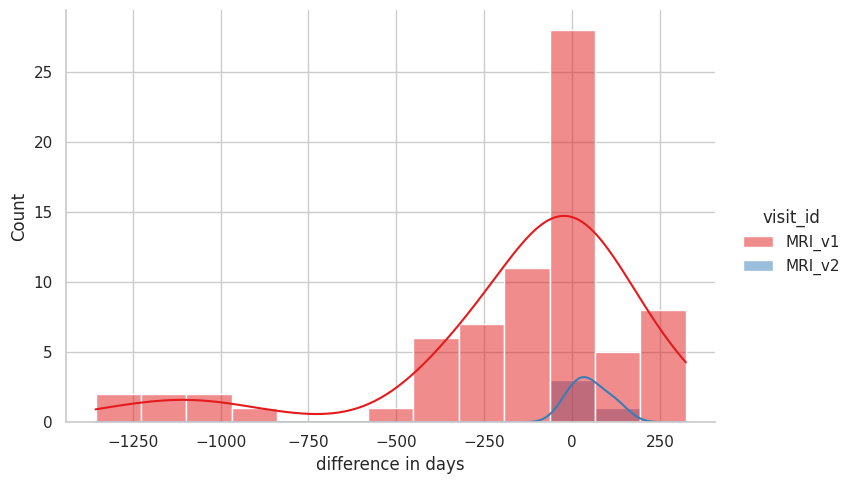

In [20]:
plot_df = date_sanity_check_df.copy()
plot_df = plot_df[plot_df["date_match"] == False]
plot_df["difference in days"] = plot_df["date_diff"].dt.days

sns.set(font_scale=1)
with sns.axes_style("whitegrid"):
    g = sns.displot(hue="visit_id", x="difference in days", data=plot_df, aspect=1.5, height=5, kde=True, palette="Set1")

In [21]:
save_date_check_csv = True
if save_date_check_csv:
    print(f"Saving save_date_check_csv here: {date_check_csv}")
    date_sanity_check_df.to_csv(date_check_csv,index=None)

Saving save_date_check_csv here: /home/nikhil/projects/Parkinsons/qpn//scratch/mri_dates_sanity_check.csv
